# Calib with the Likelihood Ratio and backgrounds

**Goal:** make a MC -> data correction with a likelihood ratio, if data _also_ has some background component.

In the `Calib-LR-no-pT` notebook, I was able to
- Identify the "oracles" or true loss that I was shooting for, and this made it _much easier_ to sort ou
- I also realized for these toy problems, it's better to evaluate these models by comparing to an analytical solution instead of making histograms
- I have the SF working both for the BCE and `louppe_loss` functions

I think with a similar setup as before, I _should_ be able to also evaluate these models with a truth "best case" loss, and this will be great for building my intuition for the problem :)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Step 0: Data generation reminder

In [4]:
N=int(1e6)

std = 3
mu = 5
delta = .5

s = mu + std* np.random.normal(size=(N,))
b = -5 + 3* np.random.normal(size=(N,))
s_data = s - delta

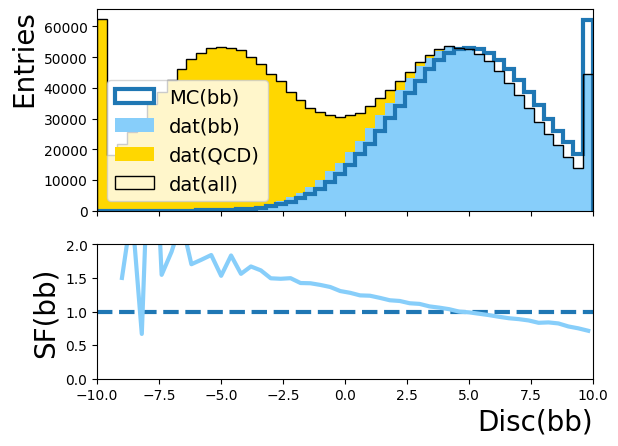

In [15]:
nb = 50
r = (-10,10)
lw = 3

fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))

c_mc = 'C0'
c_dat = 'lightskyblue'

h_mc,e,_ = ax.hist(np.clip(s,*r),nb,r,histtype='step',color=c_mc,lw=lw,label='MC(bb)')

h_dat,*_ = ax.hist(np.clip(s_data,*r),nb,r,color=c_dat,lw=lw,label='dat(bb)')
h_bkg, *_ = ax.hist(np.clip(b,*r),nb,r,color='gold',label="dat(QCD)",bottom=h_dat)
h_all,*_ = ax.hist(np.clip(np.concatenate([s_data,b]),*r),nb,r,histtype='step',color='k',lw=1,label='dat(all)')

ax_rat.plot(r,[1]*2,c_mc,ls='--',lw=lw)

# Plot the SF
xx = .5 * (e[1:] + e[:-1])
ax_rat.plot(xx[h_mc > 0],h_dat[h_mc > 0] / h_mc[h_mc > 0],color=c_dat,lw=lw)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc(bb)',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF(bb)',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


So, the SF is just dat(bb) / MC(bb), and we want to subtract off the dat(QCD) component in 

But also note at the point, the problem is analytical, we don't need to rely on histograms and samplers to setup the problem.

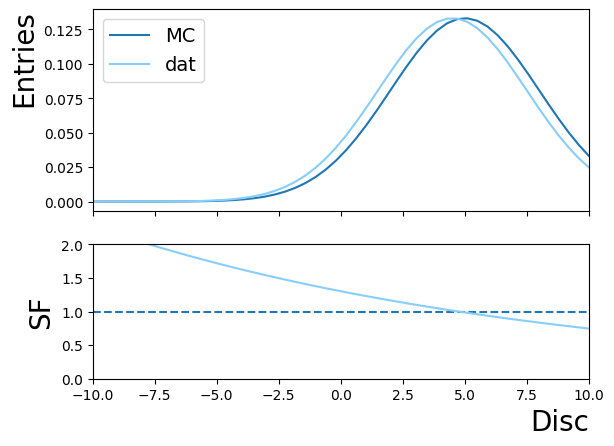

In [16]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))


ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()

### Step 1: Intution building :) Suppose I have a perfect model, what will the loss look like?

**1a) With classifiers**

Suppose we let,
- Class 0: data
- Class 1: MC
and I can train a classifier D(x) to learn the $D(x) = p_{MC}(x)$ (and since I only have two classes, then $p_{dat} = 1 - D(x)$).
Then minimize with the NLL, a.k.a, the BCE loss:

$$\mathcal{L} = \mathbb{E}_{x \sim p_{dat(bb)}} \left[ \log (1-D(x))  \right] + \mathbb{E}_{x \sim p_{MC}} \left[ \log D(x)  \right]$$

Then we know the optimal classifier will be:

$$D(x) = \frac{1}{1 + p_{dat}(x) / p_{MC}(x)}$$

which we can then rearrange for the SF:

$$SF(x) = \frac{p_{dat}(x)}{p_{MC}(x)} = \frac{1}{D(x)} - 1$$

Then for data (ofc) I'll now have to pretend like I have data getting generated that includes the background, which I'm then subtracting off. 

\begin{align}
\mathcal{L} &\approx \sum_{x_i \in p_{dat(bb)}, i = 1:N(bb)} \left[ \log (1-D(x_i))  \right] + \mathbb{E}_{x_i \sim p_{MC}, i=1:N(MC)} \left[ \log D(x_i)  \right] \\
&\approx \sum_{x_i \in p_{dat(all)}, i = 1:N(bb)+N(QCD)} \left[ \log (1-D(x_i))  \right] - \sum_{x_i \in p_{dat(QCD)}, i = 1:N(QCD)} \left[ \log (1-D(x_i))  \right] + \mathbb{E}_{x_i \sim p_{MC}, i=1:N(MC)} \left[ \log D(x_i)  \right]
\end{align}

I think this should work as long as I subtract off the data the expected number of backgrond events?

In [17]:
def get_true_SF(x):
    # See algebra below when I calculated this for the Louppe loss
    return  np.exp( - (delta * (x - mu) + .5 * delta **2 ) / (std**2) )

In [18]:
def get_opt_class(x):
    '''
    Optimal classifier
    '''
    sf = get_true_SF(x)
    return 1 / (1 + sf)


In [19]:
y_true = np.concatenate([np.zeros(N), np.ones(N) ])
y_pred = np.concatenate([ get_opt_class(s_data) , get_opt_class(s) ])

In [20]:
for i in range(1,7):
    ni = int(10**i)
    li = nn.BCELoss()(torch.FloatTensor(y_pred[:ni]), torch.FloatTensor(y_true[:ni]))
    print(ni,li.numpy())

bce_best = li.numpy()

10 0.6657031
100 0.6861246
1000 0.6902346
10000 0.689326
100000 0.6901226
1000000 0.68975866


For the optimal classifier, the loss should still get down to 0.69.

### 1b) With Giles Louppe's loss

- Class 1: MC
- Class 0: data

$$
\mathcal{L} = \mathbb{E}_{x \sim p_{MC}} \left[  \sqrt{ \exp Q(x)} \right] + \mathbb{E}_{x \sim p_{dat}} \left[ \sqrt{ \frac{1}{\exp Q(x)}} \right] $$


In [233]:
def louppe_loss(y_pred, y_true, w=None):
    '''
    Loss fct Rafael, HH4b analysis
    '''
    
    loss = (y_true * (torch.sqrt(torch.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / torch.sqrt(torch.exp(y_pred))))

    if w is None:
        return loss.mean()
    else:
        return torch.sum(loss * w) / torch.sum(w)
     

**Simplify the $\log (p_{dat}(x) / p_{MC}(x))$ formula**

\begin{align}
\log \left(\frac{p_{dat}(x)}{p_{MC}(s)}\right) &= -\frac{1}{2} ((x-(\mu-\delta))/\sigma)^2 +  \frac{1}{2} ((x-\mu)/\sigma)^2 \\
&= - \frac{1}{2} ((x-\mu)+\delta))/\sigma)^2 + \frac{1}{2} ((x-\mu)/\sigma)^2  \\
&= - (\delta (x-\mu) + 0.5 \delta^2 ) /\sigma^2
\end{align}

In [49]:
def get_true_log_SF(x):
    '''
    Note, the SF _only_ depends on the input features x (right)? 
    So whether it's a data or an MC sample, I can calculate the corresponding SF :D
    '''

    # Calculate the true SF over the elements of a mini-batch    
    return  - (delta * (x - mu) + .5 * delta **2 ) / (std**2)


Details in the OG paper: 1911.00405
G. V. Moustakides and K. Basioti, 
Training Neural Networks for Likelihood / Density Ratio Estimation 

In [108]:
y_true = np.concatenate([np.zeros(N), np.ones(N) ])
y_pred = np.concatenate([get_true_log_SF(x) for x in [s_data,s]])

idx = np.arange(2*N)
np.random.shuffle(idx)

y_true = y_true[idx]
y_pred = y_pred[idx]

In [112]:
y_true[:100]

array([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.])

In [113]:
y_pred[:100]

array([-0.17076876, -0.07215214,  0.20221742, -0.00724246, -0.33645702,
       -0.3082531 ,  0.20873867, -0.07391809, -0.2139472 , -0.07648651,
        0.1322813 , -0.08898328, -0.31962946, -0.15578528,  0.07452009,
        0.32506492, -0.05397462,  0.17153634, -0.25345465, -0.28082135,
        0.071236  ,  0.14042466,  0.18483963,  0.0490931 ,  0.04364945,
       -0.1093037 , -0.13291617,  0.27329677,  0.13856871,  0.01903271,
       -0.14455406,  0.04065416,  0.27299572,  0.12148383,  0.13074787,
       -0.06021467,  0.01858111,  0.02184744, -0.15495522,  0.49080715,
       -0.03903576, -0.33131927, -0.25597429,  0.0525721 ,  0.04104845,
       -0.03909484,  0.13083206,  0.18738306,  0.05504364, -0.20680534,
        0.15621481, -0.19428578,  0.08595686,  0.20245199,  0.03226823,
        0.29799901,  0.10827464, -0.22883133,  0.13208858,  0.07885168,
        0.18933608,  0.23857007, -0.09441022, -0.28640628, -0.10829209,
       -0.36181868, -0.03859551, -0.00794322,  0.19288007,  0.25

In [116]:
for i in range(1,7):
    ni = 2*int(10**i)
    li = louppe_loss(torch.FloatTensor(y_pred[:ni]), torch.FloatTensor(y_true[:ni]))
    print(ni,li.numpy())
louppe_best = li.numpy()

20 0.9918564
200 0.9919913
2000 0.99189246
20000 0.9964361
200000 0.99696773
2000000 0.99653596


Take away: For 2 sig figs, a batch size of 100 is fine, for 3 sig figs, want a bigger batch size of 10k.

**Step 2:** Train the reweighting functions, and see how the loss c.f. the true "best loss"

In [163]:
def make_batch(N=256, return_bkg=False):
    '''
    Batches that don't depend on the pt
    
    Inputs:
    - N: batch size

    Outputs:
    - x: tensor (4*N,1) (p_bb)
    - y: labels (4*N,)
        * 1: MC 
        * 0: data
        * 0: bkg
    - w: weights
        * The weight will be 1 for the terms that are in the MC or data(all) [s_data, b_data] components
        * Weight -1 for the b_est piece that we're subtracting off
    '''

    # "Blobs" discriminant
    s = mu + std* np.random.normal(size=(N,))
    s_data = s - 0.5

    b_data = -5 + 3* np.random.normal(size=(N,))
    b_est  = -5 + 3* np.random.normal(size=(N,))

    x = np.concatenate([s,s_data,b_data,b_est])
    y = np.concatenate([np.ones(N),np.zeros(3*N)])
    w = np.concatenate([np.ones(3*N), -np.ones(N)])
    
    # Shuffle + convert to float tensor
    idx = np.arange(len(y))
    np.random.shuffle(idx)

    x = torch.FloatTensor(x[idx]).reshape(-1,1)
    y = torch.FloatTensor(y[idx]).reshape(-1,1)
    w = torch.FloatTensor(w[idx]).reshape(-1,1)


    if return_bkg:
        return x, y, w, b_data 
    else:
        return x, y, w 


In [164]:
x,y,w = make_batch(N=8192)

In [165]:
8192*4

32768

In [166]:
x.shape

torch.Size([32768, 1])

In [167]:
y.shape

torch.Size([32768, 1])

In [168]:
w.shape

torch.Size([32768, 1])

#### Train the BCE Loss

In [176]:
H=64
m = nn.Sequential(
    nn.Linear(1,H),
    nn.ReLU(),
    nn.Linear(H,H),
    nn.ReLU(),
    nn.Linear(H,1),
    nn.Sigmoid()
)

In [177]:
Niter=1000
lr = 1e-4
Nbatch=8192

# init the optimizer
opt = torch.optim.Adam(m.parameters(),lr)
loss = []

for i in range(Niter):

    x,y,w = make_batch(Nbatch)
    
    m.zero_grad()

    y_pred = m(x)
    li = nn.BCELoss(weight=w,reduction='sum')(y_pred, y)
    li /= (2*Nbatch)
    
    li.backward()
    opt.step()

    print(i,li.item())
    loss.append(li.item())

0 0.6941007971763611
1 0.6935716271400452
2 0.6941624879837036
3 0.6936889886856079
4 0.6931996941566467
5 0.6933505535125732
6 0.6935427188873291
7 0.6933920979499817
8 0.6932168006896973
9 0.6927700042724609
10 0.693192183971405
11 0.6928552985191345
12 0.6928200125694275
13 0.6928544044494629
14 0.692761242389679
15 0.6927600502967834
16 0.6926419734954834
17 0.6926149129867554
18 0.6925781965255737
19 0.6925703287124634
20 0.6925161480903625
21 0.6925106048583984
22 0.6924835443496704
23 0.6923826336860657
24 0.6923904418945312
25 0.6923503875732422
26 0.6923200488090515
27 0.6922510862350464
28 0.6921944618225098
29 0.6920375227928162
30 0.6920627355575562
31 0.692044198513031
32 0.6919686794281006
33 0.6920055150985718
34 0.6921294331550598
35 0.6917625665664673
36 0.6918888688087463
37 0.6919078230857849
38 0.6918848752975464
39 0.6917420625686646
40 0.6918588876724243
41 0.6920344233512878
42 0.6918803453445435
43 0.6914700269699097
44 0.6914942264556885
45 0.6916427612304688
4

To keep the loss the same as if I had no bkg included, I'm going to "pretend" like I have no background, and normalize the loss by the # of bb dat and MC bb samples.

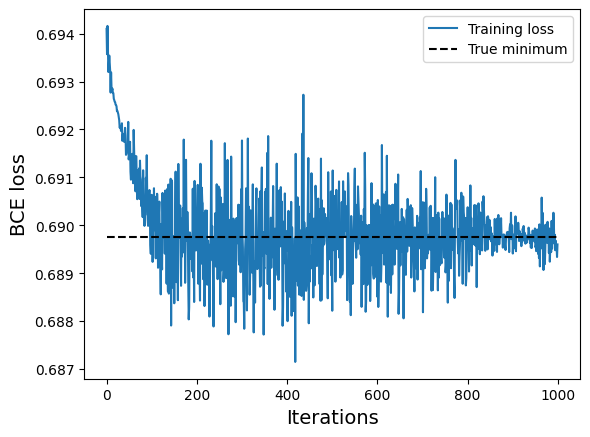

In [178]:
plt.plot(loss,label='Training loss')
plt.plot(range(Niter),[bce_best]*Niter,'k--',label='True minimum')
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('BCE loss',fontsize=14)
plt.legend()
plt.show()

Nice!! It's converging very fast :)

In [179]:
def get_SF(m,x):
    d = m(x).squeeze()
    return (1/d - 1).numpy()

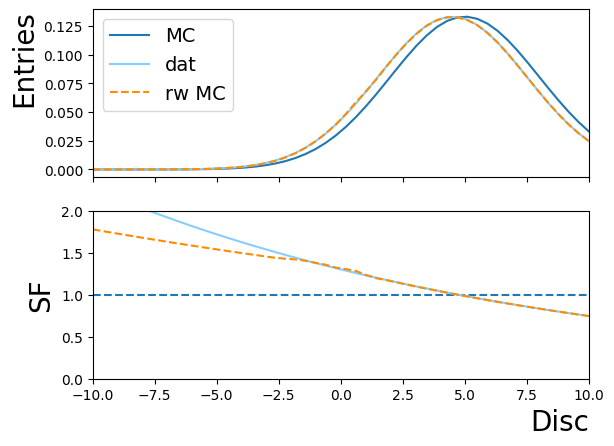

In [180]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

with torch.no_grad():
    sf = get_SF(m,torch.FloatTensor(xx).reshape(-1,1))

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.5,.5))

c_bce = 'darkorange'
ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')
ax.plot(xx,p_MC * sf,c_bce,ls='--',label='rw MC')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat,label='true SF')

ax_rat.plot(xx,sf,color=c_bce,ls='--',label='NN SF')

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC

# ax_rat.legend()

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


Hmmmmm... maybe an interesting experiment to do would be to vary the batch size, and see how the closure varies?

But, I'm super happy, b/c I have good closure until I lose support (and when we lose support, that's where there aren't any D(bb) SFs to even calculate!

#### Train the Louppe loss

In [234]:
H=64
Q = nn.Sequential(
    nn.Linear(1,H),
    nn.ReLU(),
    nn.Linear(H,H),
    nn.ReLU(),
    nn.Linear(H,1)
)

In [235]:
with torch.no_grad():
    q = Q(x)
    print(louppe_loss(Q(x),y))

tensor(1.1309)


In [236]:
1.0413/0.9965921

1.0448607810557597

Again, the NN for this toy problem is trying to learn a 2% correction.

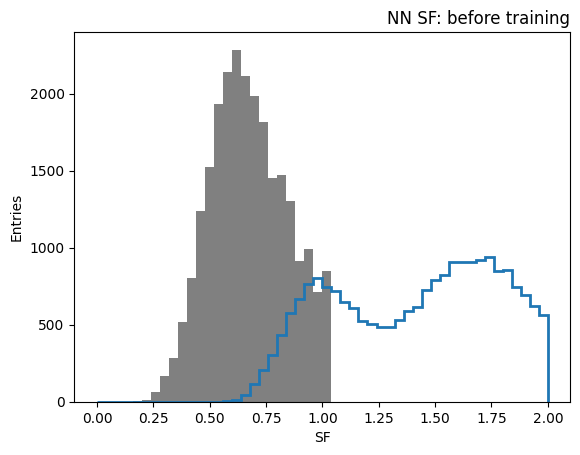

In [237]:
true_weights = np.exp(get_true_log_SF(x[y==0].numpy()))
pred_weights=np.exp(q[y==0].numpy())

plt.hist(pred_weights,nb,(0,2),color='grey',label='pred')
plt.hist(true_weights,nb,(0,2),histtype='step',color=c_mc,lw=2,label='true')
plt.xlabel('SF')
plt.ylabel('Entries')
plt.title('NN SF: before training',loc='right')
plt.show()

OK, so we can see why originally the normalization for the SF corrected histogram is smaller, at intialization, this NN has weights very close to 1.

In [238]:
Niter=500
lr = 1e-4
Nbatch=8192

# init the optimizer
opt = torch.optim.Adam(Q.parameters(),lr)
loss = []

for i in range(Niter):

    x,y,w = make_batch(Nbatch)
    
    Q.zero_grad()

    y_pred = Q(x)
    li = louppe_loss(y_pred, y, w)

    li.backward()
    opt.step()

    print(i,li.item())
    loss.append(li.item())


0 1.0299628973007202
1 1.025726079940796
2 1.021337866783142
3 1.0203797817230225
4 1.0174806118011475
5 1.0162227153778076
6 1.0135833024978638
7 1.0106137990951538
8 1.0099493265151978
9 1.0075284242630005
10 1.0056378841400146
11 1.005396842956543
12 1.0042393207550049
13 1.00221848487854
14 1.0026674270629883
15 1.0011497735977173
16 0.9995729923248291
17 0.9989166259765625
18 1.0000516176223755
19 0.996943473815918
20 0.9993157982826233
21 0.9981908798217773
22 0.9991374611854553
23 0.9979027509689331
24 0.9968395233154297
25 0.9991607069969177
26 0.997565507888794
27 0.9987413883209229
28 0.9977576732635498
29 0.9986802935600281
30 0.9983810186386108
31 0.9986749291419983
32 0.9977768063545227
33 0.9988255500793457
34 0.9981509447097778
35 0.9979255199432373
36 0.9981182813644409
37 0.9982728958129883
38 0.9992964267730713
39 0.9976757168769836
40 0.9977494478225708
41 0.9985249042510986
42 0.9975682497024536
43 0.99856036901474
44 0.9979650974273682
45 0.9977723956108093
46 0.99

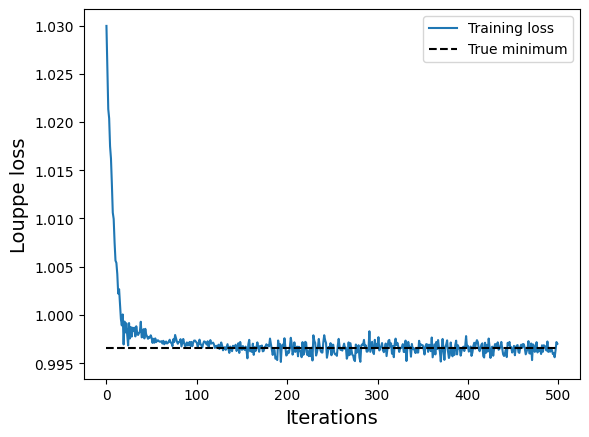

In [239]:
plt.plot(np.array(loss),label='Training loss')
plt.plot(range(Niter),[louppe_best]*Niter,'k--',label='True minimum')
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Louppe loss',fontsize=14)
plt.legend()
plt.show()

**How to diagnose?**
I think I should return a few more components here:
- The b_dat and b_est pieces, b/c then I'll be able to estimate if these are actually the same size (on average) or not

But... it's already converging reasonably well, so I can come back to this later.

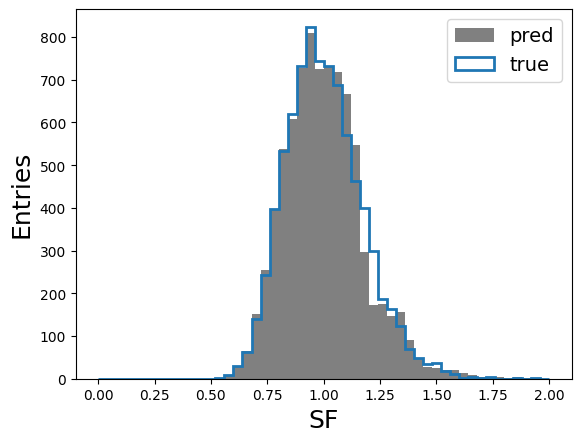

In [240]:
with torch.no_grad():
    q = Q(x)

true_weights = np.exp(get_true_log_SF(x[y==1].numpy()))
pred_weights=np.exp(q[y==1].numpy())

plt.hist(pred_weights,nb,(0,2),color='grey',label='pred')
plt.hist(true_weights,nb,(0,2),histtype='step',color=c_mc,lw=2,label='true')
plt.xlabel('SF',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(fontsize=14)
plt.show()

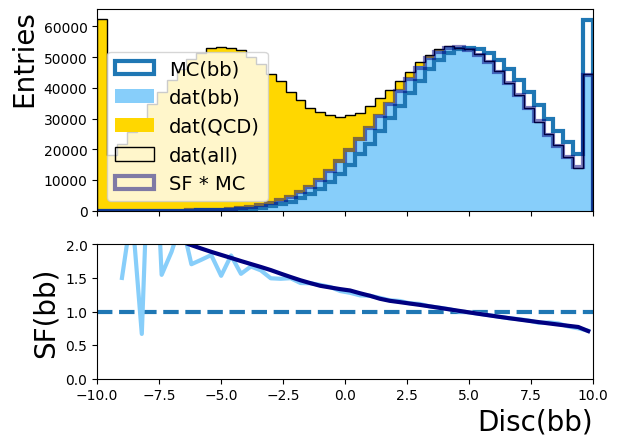

In [241]:
nb = 50
r = (-10,10)
lw = 3

fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))

c_mc = 'C0'
c_dat = 'lightskyblue'

with torch.no_grad():
    q = Q(torch.FloatTensor(s.reshape(-1,1))).squeeze().numpy()
sf = np.exp(q)

h_mc,e,_ = ax.hist(np.clip(s,*r),nb,r,histtype='step',color=c_mc,lw=lw,label='MC(bb)')

h_dat,*_ = ax.hist(np.clip(s_data,*r),nb,r,color=c_dat,lw=lw,label='dat(bb)')
h_bkg, *_ = ax.hist(np.clip(b,*r),nb,r,color='gold',label="dat(QCD)",bottom=h_dat)
h_all,*_ = ax.hist(np.clip(np.concatenate([s_data,b]),*r),nb,r,histtype='step',color='k',lw=1,label='dat(all)')
h_sf,*_ = ax.hist(np.clip(s,*r),nb,r,color='navy',alpha=.5,label='SF * MC',weights=sf,histtype='step',lw=lw)

ax_rat.plot(r,[1]*2,c_mc,ls='--',lw=lw)

# Plot the SF
xx = .5 * (e[1:] + e[:-1])
ax_rat.plot(xx[h_mc > 0],h_dat[h_mc > 0] / h_mc[h_mc > 0],color=c_dat,lw=lw)
ax_rat.plot(xx[h_mc > 0],h_sf[h_mc > 0] / h_mc[h_sf > 0],color='navy',lw=lw)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc(bb)',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF(bb)',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


Nice! it looks good (sort of by construction)

Let's also check the continuous space:

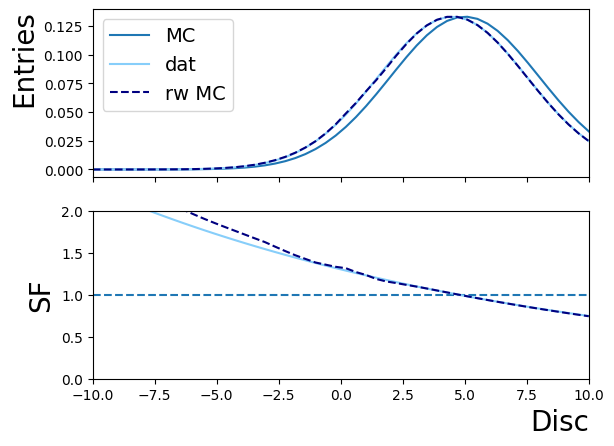

In [242]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

with torch.no_grad():
    q = Q(torch.FloatTensor(xx).reshape(-1,1)).squeeze().numpy()
sf = np.exp(q)

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.5,.5))

c_rw = 'navy'
ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')
ax.plot(xx,p_MC * sf,c_rw,ls='--',label='rw MC')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat,label='true SF')

ax_rat.plot(xx,sf,color=c_rw,ls='--',label='NN SF')

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC


# ax_rat.legend()

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


**Summary thoughts** 
- Gosh, it was a really silly mistake I had made before in the old notebook
- But ... great that it's corrected and _super easy to learn_!!

**Next step:**  Scale up the dimensions, a.k.a, add the $p_T$ dependence on the problem!
